Simple quick update latest weather

* switched to new sensor 8am BDA 2015-08-21 Old sensor was giving systematic bias and other weirdness.

In [145]:
# Tell matplotlib to plot in line
%matplotlib inline

import datetime

# import pandas
import pandas

# seaborn magically adds a layer of goodness on top of Matplotlib
# mostly this is just changing matplotlib defaults, but it does also
# provide some higher level plotting methods.
import seaborn

# Tell seaborn to set things up
seaborn.set()

def smooth(data, thresh=None):
    """ This smoothing function is meant to spot and eliminate bad readings.
    
    """ 
    
    means = data.mean()

    if thresh is None:
        sds = data.std()
    else:
        sds = thresh
    
    delta = data - data.shift()
    
    good = delta[abs(delta) < sds]

    #print(good.describe())
    
    return delta.where(good, 0.0)


In [181]:
infile = "../files/kittycam_weather.csv"

!scp 192.168.0.121:Adafruit_Python_BMP/weather.csv $infile

weather.csv                                   100% 5850KB   5.7MB/s   00:01    


In [147]:
!wc ../files/weather.csv

  564  1127 56016 ../files/weather.csv


In [148]:
""" assume it is csv and let pandas do magic

  index_col tells it to use the 'date' column in the data
  as the row index, plotting picks up on this and uses the
  date on the x-axis

  The *parse_dates* bit just tells it to try and figure out
  the date/time in the columne labeled 'date'.
"""
data = pandas.read_csv(infile, index_col='date', parse_dates=['date'])

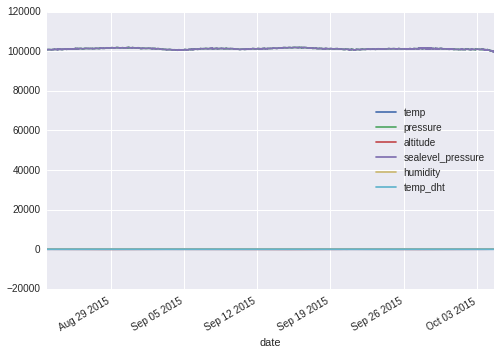

In [149]:
data.plot()

In [150]:
# smooth the data to filter out bad temps and pressures
#data.altitude = (smooth(data.altitude, 5.0).cumsum() + data.altitude[0])
#data.temp = (smooth(data.temp, 5.0).cumsum() + data.temp[0])
#data.altitude = data.altitude.clip(-100, 100)

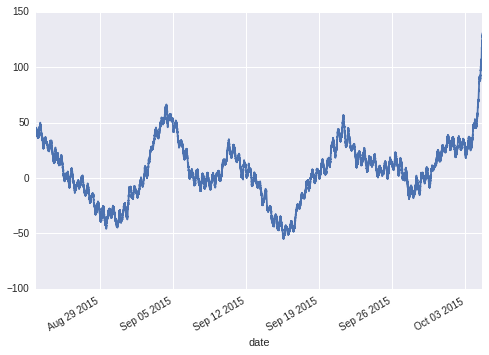

In [151]:
data.altitude.plot()

In [152]:
data.tail()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht
date,,,,,,
2015-10-04 14:59:04.029159,26.4,99788,128.924064,99791,82.500000,25.9
2015-10-04 15:00:04.671297,26.4,99808,127.069788,99808,82.500000,25.9
2015-10-04 15:01:05.262094,26.5,99791,129.429833,99788,82.500000,25.9
2015-10-04 15:02:05.904264,26.5,99766,129.935627,99767,82.599998,25.9
2015-10-04 15:03:06.546427,26.5,99758,130.525751,99773,82.400002,25.9


In [153]:
data.describe()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht
count,60281.000000,60281.000000,60281.000000,60281.000000,60281.000000,60281.000000
mean,27.892394,101246.221778,6.548877,101247.144722,63.323885,27.275608
std,1.717909,315.289819,26.273290,315.299968,12.424934,1.718179
min,22.500000,99758.000000,-55.052172,99767.000000,28.700001,21.799999
25%,26.900000,101027.000000,-8.738071,101028.000000,58.099998,26.299999
50%,28.000000,101251.000000,6.079362,101252.000000,66.500000,27.500000
75%,29.000000,101430.000000,24.756020,101431.000000,71.599998,28.400000
max,31.400000,101985.000000,130.525751,101985.000000,88.500000,30.600000


## Dew Point

The warmer air is, the more moisture it can hold.  The *dew point* is
the temperature at which air would be totally saturated if it had as 
much moisture as it currently does. 

Given the temperature and humidity the *dew point* can be calculated, the actual formula is
pretty complex.

It is explained in more detail here: http://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html

>If you are interested in a simpler calculation that gives an approximation of dew point temperature if you know >the observed temperature and relative humidity, the following formula was proposed in a 2005 article by Mark G. >Lawrence in the Bulletin of the American Meteorological Society:

$$Td = T - ((100 - RH)/5.)$$


In [154]:
data['dewpoint'] = data.temp - ((100. - data.humidity)/5.)

### Last 24 hours:

In [155]:
print(datetime.datetime.now())
print(data.ix[-1:])

2015-10-04 12:04:12.700504
                            temp  pressure    altitude  sealevel_pressure  \
date                                                                        
2015-10-04 15:03:06.546427  26.5     99758  130.525751              99773   

                             humidity  temp_dht  dewpoint  
date                                                       
2015-10-04 15:03:06.546427  82.400002      25.9     22.98  


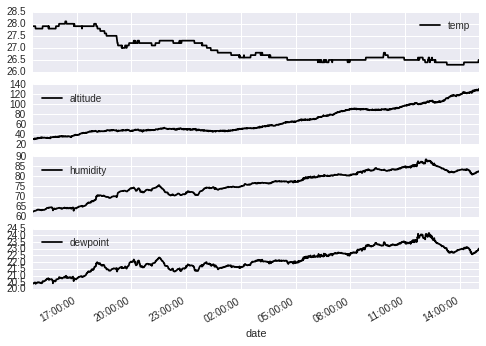

In [156]:
# reading is once a minute, so take last 24 * 60 readings
def plotem(data, n=-60, start=None):
        
    
    if n < 0:
        start = n
        end = len(data)
    else:
        start = start or 0
        end = start + n
        
    data[['temp', 'altitude', 'humidity', 'dewpoint']][start:end].plot(subplots=True)

# last few hours
plotem(data, -24*60)

### Last week

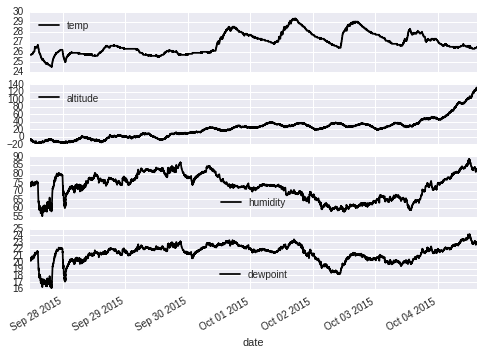

In [157]:
# reading is once a minute, so take last 7 * 24 * 60 readings
plotem(data, -7*24*60)

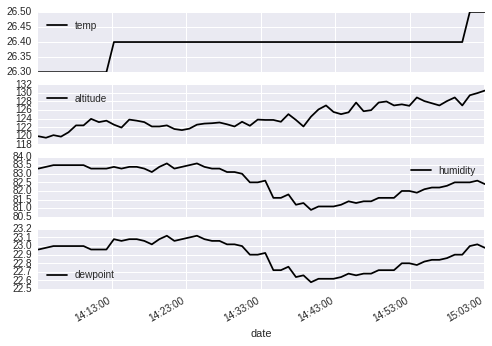

In [158]:
plotem(data)

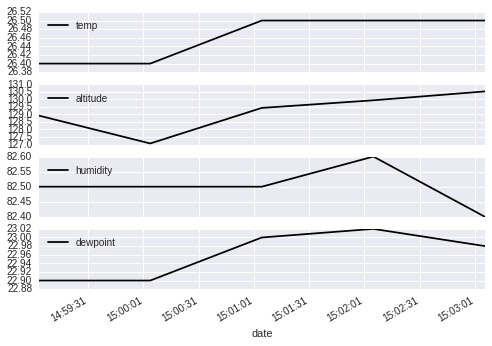

In [159]:
plotem(data, -5)

## Look at all the data

In [160]:
data.describe()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht,dewpoint
count,60281.000000,60281.000000,60281.000000,60281.000000,60281.000000,60281.000000,60281.000000
mean,27.892394,101246.221778,6.548877,101247.144722,63.323885,27.275608,20.557171
std,1.717909,315.289819,26.273290,315.299968,12.424934,1.718179,3.586928
min,22.500000,99758.000000,-55.052172,99767.000000,28.700001,21.799999,8.660000
25%,26.900000,101027.000000,-8.738071,101028.000000,58.099998,26.299999,19.820000
50%,28.000000,101251.000000,6.079362,101252.000000,66.500000,27.500000,21.620000
75%,29.000000,101430.000000,24.756020,101431.000000,71.599998,28.400000,22.939999
max,31.400000,101985.000000,130.525751,101985.000000,88.500000,30.600000,26.020000


I currently have two temperature sensors:

* DHT22 sensor which gives temperature and humidity.
* BMP180 sensor which gives pressure and temperature.

The plot below shows the two temperature plots.

Both these sensors are currently in my study.  For temperature and humidity I would like to have some readings from outside.  If I can solder them to a phone jack then I can just run phone cable to where they need to be.

**Below** plots the current values from these sensors.  This is handy for calibration.

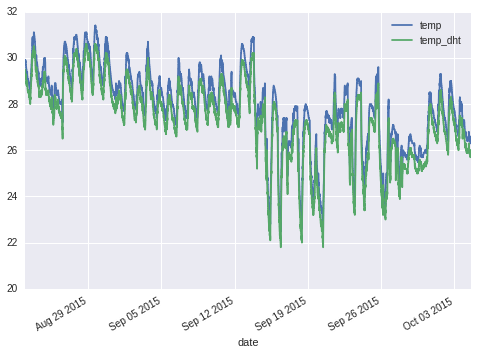

In [161]:
data[['temp', 'temp_dht']].plot()

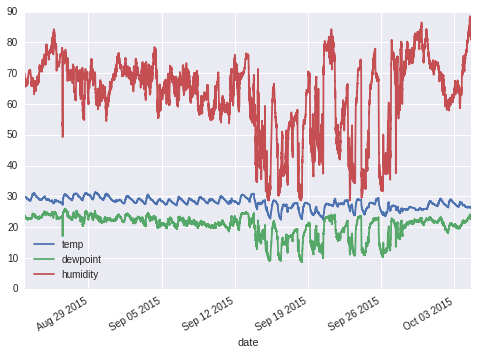

In [162]:
data[['temp', 'dewpoint', 'humidity']].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f06f432a9e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f06f3ea7f60>], dtype=object)

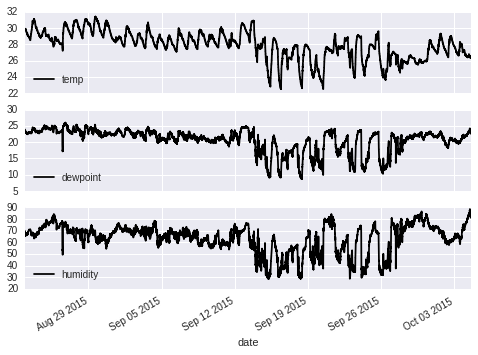

In [163]:
data[['temp', 'dewpoint', 'humidity']].plot(subplots=True)

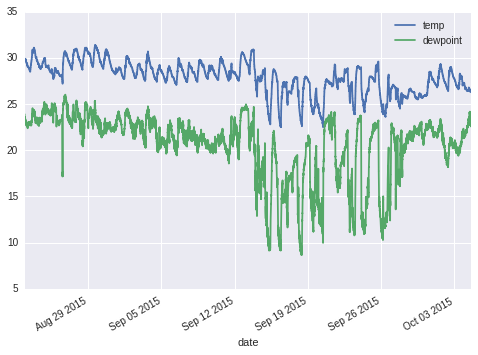

In [164]:
data[['temp', 'dewpoint']].plot()

In [165]:
from numpy import fft

In [166]:
data['fft_altitude'] = fft.fft(data.altitude)
data['fft_alt_real'] = data.fft_altitude.real
data['fft_alt_imag'] = data.fft_altitude.imag


In [167]:
data['alt_power'] = ((data.fft_alt_real ** 2.0) + (data.fft_alt_imag ** 2.0)) ** 0.5

85.14265536723164 85


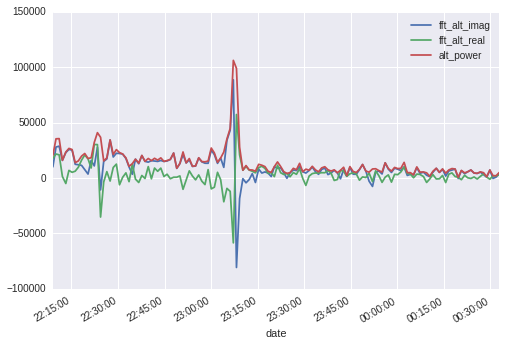

In [168]:
import numpy
N = len(data)
TWELVE = N//(12*59)

def hours(pos):
    return N/(pos*60.) 


eleven_elevator = N/(12*59.0)   # Scottish elevator
print(eleven_elevator, TWELVE)
data['pos'] = numpy.arange(N)
data[['fft_alt_imag', 'fft_alt_real', 'alt_power']][TWELVE//3:2*TWELVE].plot()

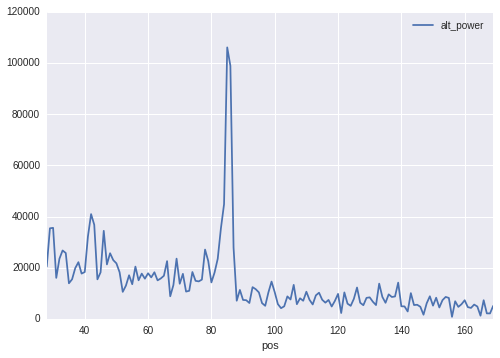

In [169]:
data[TWELVE//3:2*TWELVE].plot(x='pos', y='alt_power')

85 85.14265536723164


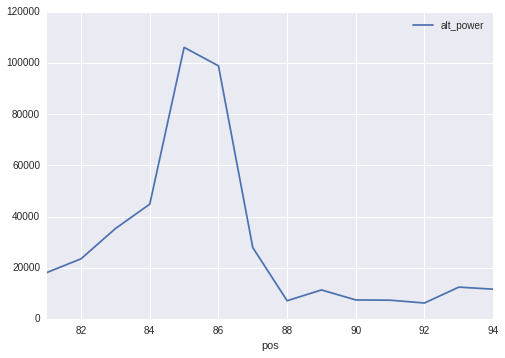

In [170]:
data[TWELVE-4: TWELVE+10].plot(x='pos', y='alt_power')
print(TWELVE, eleven_elevator)

In [171]:
#FIXME - the data points are probably a fraction over a minute apart.
for x in range(TWELVE-5, TWELVE+5):
    print(x, "%6.4f" % hours(x))

80 12.5585
81 12.4035
82 12.2522
83 12.1046
84 11.9605
85 11.8198
86 11.6824
87 11.5481
88 11.4169
89 11.2886


In [172]:
data.tail(1)

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht,dewpoint,fft_altitude,fft_alt_real,fft_alt_imag,alt_power,pos
date,,,,,,,,,,,,
2015-10-04 15:03:06.546427,26.5,99758,130.525751,99773,82.400002,25.9,22.98,(250838.166745-103601.889966j),250838.166745,-103601.889966,271391.115368,60280


In [173]:
data.tail(10*24*60).head(1)

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht,dewpoint,fft_altitude,fft_alt_real,fft_alt_imag,alt_power,pos
date,,,,,,,,,,,,
2015-09-24 10:03:41.189865,24.2,101185,11.91222,101187,35.799999,23.6,11.36,(-46.1226318013-240.511319049j),-46.122632,-240.511319,244.893838,45881


In [174]:
hours(54)

18.605246913580245

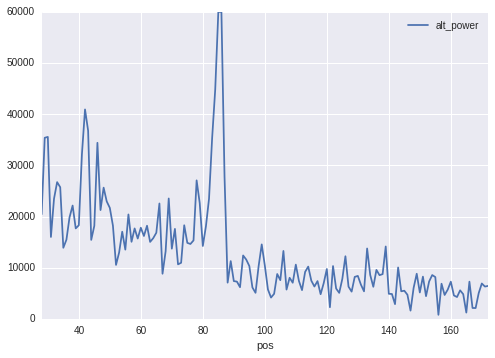

In [175]:
data[TWELVE//3:3 + (2*TWELVE)].clip(-60000, 60000).plot(x='pos', y='alt_power')

In [176]:
xx = data.fft_altitude.copy()
xx[TWELVE:-TWELVE] = 0.0
data['smooth_alt'] = [x.real for x in fft.ifft(xx)]

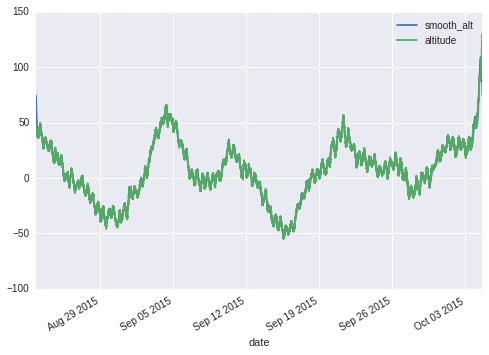

In [177]:
data[['smooth_alt', 'altitude']].plot()

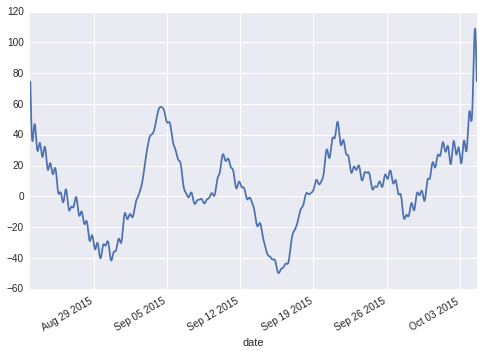

In [178]:
data.smooth_alt.plot()

In [179]:
def power(x, y):
    
    return ((x ** 2.0) + (y ** 2.0)) ** 0.5

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f06f391c6d8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f06f386e3c8>], dtype=object)

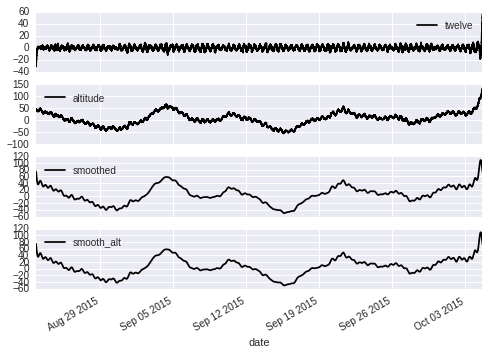

In [180]:
P = TWELVE
xx = data.fft_altitude.copy()
xx[:] = 0.0
xx[P:-P] = data.fft_altitude[P:-P]
data['twelve'] = [x.real for x in fft.ifft(xx)]
data['itwelve'] = [x.imag for x in fft.ifft(xx)]
data['twelve_pow'] = power(data.twelve, data.itwelve)
data['smoothed'] = data.altitude - data.twelve
data[['twelve', 'altitude', 'smoothed', 'smooth_alt']].plot(subplots=True)